In [3]:
import lightkurve as lk
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import light_curve as lc
from astroquery.vizier import Vizier

%matplotlib inline

In [463]:
FLARE_AMPLITUDE = 0.1
AUTHOR = 'SPOC'
CATALOG_ID = 'J/AJ/159/60/table1'
COLUMNS = ['TIC', 'tpeak', 'Amp', 'Sec', 'e_tpeak', 'E_tpeak', 'FWHMdt']

In [470]:
# random generator setting

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [464]:
# got flares data from vizier

v = Vizier(columns=COLUMNS)
v.ROW_LIMIT = 9999999

res = v.query_constraints(CATALOG_ID)
tess_flares = res[0]

tess_flares = tess_flares[tess_flares['Amp'] > FLARE_AMPLITUDE].to_pandas()

In [296]:
from bisect import bisect

def getFlare(flare_meta):
    
    tic = int(flare_meta['TIC'])
    sector = int(flare_meta['Sec'])
    amp = flare_meta['Amp']
    fwhm = flare_meta['FWHMdt']
    
    light_curve = lk.search_lightcurve(f'TIC{tic}', author=AUTHOR, sector=sector).download()

    flare_time = Time(flare_meta['_tab2_5'], format='jd')
    fwhm = flare_meta['FWHMdt']

    flare = light_curve[(light_curve['time'].mjd <= flare_time.mjd + 0.5) & (light_curve['time'].mjd >= flare_time.mjd - 0.5)]
        
    mag = -2.5 * np.log10(np.array(flare.flux))
    
    nonzero = flare.flux.nonzero()
    flare = flare[nonzero]
    
    # check if the flare in the nonzero array
    flare_idx = np.searchsorted(flare.time, flare_time)
    
    if flare_idx == len(flare.time) or flare_idx == 0:
        return [tic, None, None, None]
    
    return [tic, flare.time.mjd, flare.flux, flare.flux_err, flare_time.mjd]

In [ ]:
# CODE TO GENERATE A CSV TABLE WITH TESS TEMPLATES
# IT TAKES RATHER A LONG TIME (about ~50 minutes)

# templates_df = pd.concat([pd.DataFrame([getFlare(row)], 
#                           columns=['TIC', 'mjd', 'flux', 'flare_time']) for _, row in tess_flares.iterrows()], 
#                           ignore_index=True)
# templates_df.to_csv('tess_templates.csv', index=False)

In [226]:
import ast

def from_np_array(array_string):
    if not isinstance(array_string, str):
        return array_string
    
    array_string = array_string.replace('electron / s', '')
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [318]:
templates_df = pd.read_csv('tess_templates.csv')

templates_df['flux'] = templates_df['flux'].map(lambda x: from_np_array(x))
templates_df['mjd'] = templates_df['mjd'].map(lambda x: from_np_array(x))

templates_df = templates_df[templates_df['flare_time'].notnull()]

In [328]:
distributions = pd.read_csv('filter_mag_magerr_nolim.csv', names=['n', 'mag', 'magerr', 'filter'])

In [329]:
mag_filter1 = distributions[distributions['filter'] == 1].groupby('mag', as_index = False)['n'].sum()
mag_filter2 = distributions[distributions['filter'] == 2].groupby('mag', as_index = False)['n'].sum()
mag_filter3 = distributions[distributions['filter'] == 3].groupby('mag', as_index = False)['n'].sum()

In [452]:
from scipy.interpolate import interp1d

def genMagerr(filter, mag):
    distr = distributions[distributions['filter'] == filter]
    sorted_mag = np.sort(distr['mag'])
    bin_idx = np.searchsorted(sorted_mag, mag)

    bin_mag = sorted_mag[bin_idx-1]

    distr = distr[distr['mag'] == bin_mag].groupby('magerr', as_index = False)['n'].sum()
    
    bins = np.arange(min(distr['magerr']), max(distr['magerr']), 0.05)
    bins_map = dict.fromkeys(bins, 0)
    
    for i in range(distr.shape[0]):
        magerr = distr.iloc[i]['magerr']
        q = distr.iloc[i]['n']
        bins_map[magerr] = q
    
    cdf = np.cumsum(list(bins_map.values()))
        
    cdf = cdf / cdf[-1]
    u = rng.uniform(min(cdf), 1)
    
    func_interp = interp1d(cdf, list(bins_map.keys()))
    samples = func_interp(u)
    
    return samples

In [366]:
import itertools

def find_closest(array, x):
    return np.argmin(np.abs(array - x))

def get2dHist(filter, bins_mag, bins_sigma, counts, n_x, n_y):
    keys = [(x, y) for x, y in zip(bins_mag, bins_sigma)]
    hist_dict = {k:v for k, v in zip(keys, counts)}
    
    xedge = np.linspace(min(bins_mag), max(bins_mag), n_x)
    yedge = np.linspace(min(bins_sigma), max(bins_sigma), n_y)
    
    true_keys = list(itertools.product(xedge, yedge))
    true_dict = np.zeros((n_x, n_y))

    for (x, y), count in hist_dict.items():
            i = find_closest(xedge, x)
            j = find_closest(yedge, y)
            
            true_dict[i, j] = count    
            
    plt.pcolormesh(yedge, xedge, true_dict)
    plt.xlabel('sigma')
    plt.ylabel('mag')
    plt.title(f'filter {filter}')
    
    return xedge, yedge, true_dict

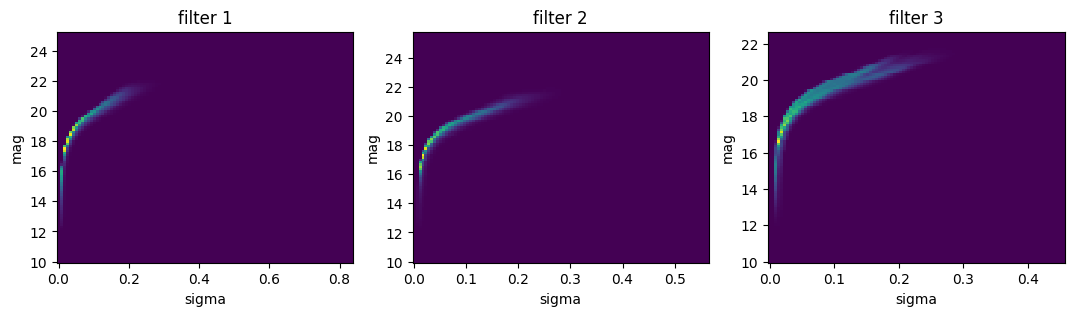

In [369]:
plt.figure(figsize=(13, 3))

plt.subplot(131)
distr_filter = distributions[distributions['filter'] == 1]

xedge, yedge, counts = get2dHist(1, distr_filter['mag'].to_numpy(), 
                                    distr_filter['magerr'].to_numpy(), 
                                    distr_filter['n'].to_numpy(), 100, 100)


plt.subplot(132)
distr_filter = distributions[distributions['filter'] == 2]

xedge, yedge, counts = get2dHist(2, distr_filter['mag'].to_numpy(), 
                                    distr_filter['magerr'].to_numpy(), 
                                    distr_filter['n'].to_numpy(), 100, 100)

plt.subplot(133)
distr_filter = distributions[distributions['filter'] == 3]

xedge, yedge, counts = get2dHist(3, distr_filter['mag'].to_numpy(), 
                                    distr_filter['magerr'].to_numpy(), 
                                    distr_filter['n'].to_numpy(), 100, 100)

In [352]:
'''
Function, which returns interpolated CDF for the required filter
'''

def genMagCdf(filter, plot_hist=False):
    statistics = [mag_filter1, mag_filter2, mag_filter3]
    stats = statistics[filter-1]

    bins = np.arange(min(stats['mag']), max(stats['mag']), 0.1)
    bins_map = dict.fromkeys(bins, 0)

    for i in range(stats.shape[0]):
        mag = stats.iloc[i]['mag']
        q = stats.iloc[i]['n']
        bins_map[mag] = q

    if plot_hist:
        bins = list(bins_map.values())
        plt.stairs(bins[:-1], list(bins_map.keys()), fill=True)
        plt.xlabel('magnitude')
        plt.ylabel('n')
        plt.title(f'filter = {filter}')
        
    cdf = np.cumsum(list(bins_map.values()))
    cdf = cdf / cdf[-1]

    func_interp = interp1d(cdf, list(bins_map.keys()))

    return func_interp

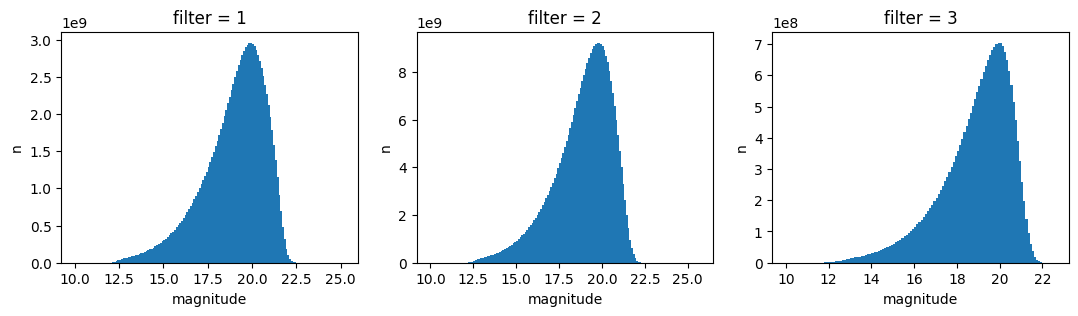

In [353]:
plt.figure(figsize=(13, 3))
plt.subplot(131)
genMagCdf(1, plot_hist=True)
plt.subplot(132)
genMagCdf(2, plot_hist=True)
plt.subplot(133)
genMagCdf(3, plot_hist=True)

In [354]:
cdf_filter1 = genMagCdf(1)
cdf_filter2 = genMagCdf(2)
cdf_filter3 = genMagCdf(3)

cdf = [cdf_filter1, cdf_filter2, cdf_filter3]

In [453]:
'''
Returns sampled magnitude from precalculated CDF
'''

def genMagnitude(n, filter):
    u = rng.uniform(0, 1, n)
    
    func_interp = cdf[filter-1]
    samples = func_interp(u)
    
    return samples

In [370]:
from ast import literal_eval

ztf_cadence = pd.read_csv('dr13_cadence.csv', header=None)
ztf_cadence[1] = ztf_cadence[1].map(lambda x: np.array(literal_eval(x))[:, 1])

In [ ]:
# закрепить генератор случайных чисел

In [454]:
from scipy.interpolate import interp1d

def flux2Mag(flux):
    mag = -2.5 * np.log10(flux) 
    return mag

def getZtfLc(lc):
    t = lc['mjd'].to_numpy()[0].copy()
    flux = lc['flux'].to_numpy()[0].copy()
    flare_time = lc['flare_time'].to_numpy()[0].copy()
        
    cadence = ztf_cadence.sample(random_state=rng)
    cad = cadence[1].to_numpy()[0].copy()
    filter = cadence[3].to_numpy()[0].copy()
    
    ztf_t = cad.copy()
    
    normalize = min(ztf_t) - min(t)
    flare_time += normalize
    t += normalize

    time_after_flare = max(t) - flare_time
    time_before_flare = flare_time - min(t)

    # we shoul check if time before/after flare point
    # is less than the full cadence duration and adjust offset's interval according to it
    
    if time_after_flare < (max(ztf_t) - min(ztf_t)):
        a = flare_time
    else:
        a = min(ztf_t)
        
    if time_before_flare < (max(ztf_t) - min(ztf_t)):
        b = flare_time
    else:
        b = max(ztf_t)
    
    offset = rng.uniform(a, b)
    off = offset - flare_time
    off_t = t + off
        
    f = interp1d(off_t, flux / min(flux))
    
    star_magnitude = genMagnitude(1, filter)
    mag_f = lambda x: flux2Mag(f(x)) + star_magnitude
    mag = np.array(mag_f(ztf_t))
    sigma = np.array([genMagerr(filter, i) for i in mag])
    
    return (np.array(cad), mag + rng.normal(size=len(cad)) * sigma, sigma, cadence.index[0], flare_time) 

In [471]:
generated_objects = pd.DataFrame(columns=['TIC', 'mjd', 'mag', 'magerr', 'flare_time', 'chi2', 'cadence_id'])

In [472]:
redchi2 = lc.ReducedChi2()

for i in range(10):
    flare = templates_df.sample(random_state=rng)
    tic = flare['TIC'].values[0]
        
    mjd, mag, magerr, cadence_index, flare_time = getZtfLc(flare)
    val = redchi2(mjd, mag, np.array(magerr))
    row = [[tic, mjd, mag, magerr, flare_time, val[0], cadence_index]]
    
    generated_objects = pd.concat([generated_objects, pd.DataFrame(row, columns=['TIC',
                                                                                 'mjd', 
                                                                                 'mag', 
                                                                                 'magerr', 
                                                                                 'flare_time', 
                                                                                 'chi2',
                                                                                 'cadence_id'])])

In [384]:
generated_objects.to_csv('generated_250k.csv')

In [660]:
CHI_LIMIT = 11

In [137]:
mean = generated_objects['mag'].map(lambda x: np.mean(x))

In [138]:
subs = generated_objects.iloc[np.where(mean > 20)[0]]

In [141]:
subs[subs['chi2'] > 11]

,Unnamed: 0,TIC,mjd,mag,magerr,flare_time,chi2,cadence_id
28,28,230982053,"[58699.21568, 58699.21613, 58699.22679, 58699....","[20.91310264, 20.64079624, 21.06115253, 21.077...","[0.18823194, 0.2065208, 0.19066584, 0.22535991...",58699.715243,17.317700,220098
321,321,238194430,"[58314.26177, 58314.26223, 58314.26314, 58314....","[20.45798264, 20.42612775, 20.52290284, 20.619...","[0.16984564, 0.19243355, 0.13484555, 0.1857665...",58314.760653,39.219491,1047
424,424,279742103,"[58719.18055, 58719.181, 58719.18996, 58719.19...","[20.60715179, 20.6204972, 20.42864593, 20.6963...","[0.13265247, 0.14467445, 0.12994701, 0.1558674...",58719.680510,14.310678,20877
1441,1441,47424649,"[58672.23978, 58672.24023, 58672.24891, 58672....","[20.51833161, 20.45842402, 20.74216598, 20.554...","[0.15894768, 0.13351466, 0.16045306, 0.1384106...",58672.738729,14.192468,156065
1664,1664,141334293,"[58864.25624, 58864.25669, 58864.25714, 58864....","[20.95783166, 20.67586449, 21.22209359, 20.789...","[0.17529206, 0.1848991, 0.14473883, 0.14952313...",58864.755384,26.010601,104984
...,...,...,...,...,...,...,...,...
251812,0,206544316,"[58487.34452, 58487.34498, 58487.34543, 58487....","[21.03174889, 20.7131308, 21.27620944, 21.0284...","[0.17593212, 0.18574099, 0.20311484, 0.1795988...",58487.843671,12.401952,93153
251921,0,177309964,"[58670.22576, 58670.22622, 58670.22816, 58670....","[20.89666708, 20.84156129, 20.97887657, 19.654...","[0.17501661, 0.18112971, 0.18876257, 0.0915792...",58670.724943,12.751257,121101
252477,0,260972843,"[59020.40243, 59020.40291, 59020.40337, 59020....","[20.87021401, 21.15863158, 20.85197715, 20.999...","[0.16542749, 0.20137858, 0.18383042, 0.1569262...",59020.901265,19.851808,49494
252495,0,201792346,"[58727.20137, 58727.20182, 58727.20851, 58727....","[20.47810459, 20.37307858, 19.10673, 19.891295...","[0.12523166, 0.14556744, 0.05492843, 0.0943291...",58727.700446,27.484095,73816


In [750]:
generated_objects[generated_objects['chi2'] > 11]

,TIC,mjd,mag,magerr,flare_time,chi2,cadence_id
6,309791561,"[58806.25694, 58806.25739, 58806.25784, 58806....","[17.99008881, 17.95548372, 18.06518315, 18.014...","[0.02426633, 0.04899986, 0.02989842, 0.0274886...",58806.756852,34.829956,111063
7,425937691,"[58343.19417, 58343.19509, 58343.19602, 58343....","[17.24655539, 17.25340757, 17.26651325, 17.293...","[0.01722005, 0.02108515, 0.01778887, 0.0174425...",58343.693598,16.989371,66051
16,266923326,"[58719.17276, 58719.17321, 58719.18701, 58719....","[14.37472887, 14.40073073, 14.41083389, 14.395...","[0.00824226, 0.01371851, 0.01559018, 0.0143996...",58719.671764,47.460199,66744
18,260655797,"[58663.23942, 58663.23987, 58663.25346, 58663....","[14.6229777, 14.57123977, 14.50166653, 14.5423...","[0.01193397, 0.01095371, 0.00969185, 0.0094799...",58663.738971,16.270044,134351
28,230982053,"[58699.21568, 58699.21613, 58699.22679, 58699....","[20.91310264, 20.64079624, 21.06115253, 21.077...","[0.18823194, 0.2065208, 0.19066584, 0.22535991...",58699.715243,17.317700,220098
...,...,...,...,...,...,...,...
0,141769356,"[58741.27251, 58741.27296, 58741.27447, 58741....","[15.291206083379546, 15.295064148419387, 15.27...","[0.009751807542105853, 0.008853957132062787, 0...",58741.771556,87.494997,15306
0,389426731,"[58449.06836, 58449.06929, 58449.0702, 58449.0...","[15.741697739664442, 15.76711659738626, 15.754...","[0.012229723656338846, 0.013256798680566935, 0...",58449.567393,37.510361,112855
0,12423835,"[58670.21866, 58670.22729, 58670.23072, 58670....","[19.61786563047339, 19.39975271396866, 19.3667...","[0.08445727421894417, 0.08342523864635495, 0.0...",58670.717417,25.999695,214323
0,281542064,"[58688.22505, 58688.2255, 58688.22984, 58688.2...","[19.018585477714097, 19.113565509055714, 19.05...","[0.07399585015330536, 0.05578435149090493, 0.0...",58688.724376,113.432436,47278


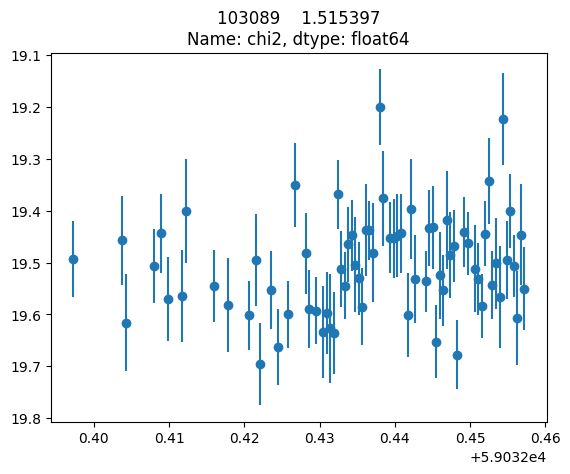

In [152]:
random = generated_objects[generated_objects['chi2'] < 2].sample()
# random = subs[subs['chi2'] > CHI_LIMIT].sample()

plt.errorbar(random['mjd'].to_numpy()[0], random['mag'].to_numpy()[0], random['magerr'].to_numpy()[0], fmt='o')
plt.title(str(random['chi2']))
plt.gca().invert_yaxis()  

In [9]:
import ast

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [10]:
generated_objects = pd.read_csv('generated_250k.csv', 
                                converters={'mjd': from_np_array, 'mag': from_np_array, 'magerr': from_np_array},
                                index_col=False)

In [154]:
# сохранять oid для каденса + поле и фильтр

In [158]:
generated_objects.to_csv('generated_flare_250k.csv')

In [160]:
pd.read_csv('generated_flare_250k.csv', converters={'mjd': from_np_array, 'mag': from_np_array, 'magerr': from_np_array})

,Unnamed: 0,TIC,mjd,mag,magerr,flare_time,chi2,cadence_id
0,0,401838575,"[58670.22392, 58670.22437, 58670.23171, 58670....","[18.93377643, 18.92693795, 19.00985149, 18.901...","[0.06915677, 0.04368783, 0.05546116, 0.0469365...",58670.723244,6.771148,210139
1,1,229137237,"[58806.40329, 58806.40373, 58806.40419, 58806....","[18.44983858, 18.42632196, 18.53543563, 18.453...","[0.03816467, 0.03277796, 0.04178508, 0.0351525...",58806.901907,3.640815,48965
2,2,332517282,"[58726.17404, 58726.18414, 58726.19523, 58726....","[19.44587903, 19.30531509, 19.32871613, 19.300...","[0.0738861, 0.06057421, 0.05880634, 0.05329344...",58726.673042,2.153495,93224
3,3,339607562,"[58867.27681, 58867.27726, 58867.27771, 58867....","[16.17774176, 16.16988355, 16.18240478, 16.180...","[0.01113228, 0.01237234, 0.01352517, 0.0131262...",58867.776362,2.829389,35478
4,4,160113240,"[58719.1751, 58719.17555, 58719.19013, 58719.1...","[15.73534893, 15.72950935, 15.78411225, 15.781...","[0.01236958, 0.01081624, 0.01256477, 0.0229319...",58719.674024,4.621342,194336
...,...,...,...,...,...,...,...,...
252796,252796,302296434,"[58468.09283, 58468.09329, 58468.09374, 58468....","[17.18965567, 17.14352202, 17.1644606, 17.2004...","[0.01589039, 0.0162306, 0.01590003, 0.01871675...",58468.592005,2.607492,37118
252797,252797,382243958,"[58719.17305, 58719.1735, 58719.18731, 58719.1...","[18.96821121, 19.07609905, 18.92866044, 19.102...","[0.05509176, 0.04845715, 0.0962942, 0.06836221...",58719.672071,4.316107,69586
252798,252798,206609630,"[58287.35417, 58287.35462, 58287.35553, 58287....","[17.78263288, 17.79559713, 17.76414208, 17.745...","[0.05447452, 0.02552808, 0.02042474, 0.0271241...",58287.853816,1.852205,201325
252799,252799,77041173,"[58348.21776, 58348.22511, 58348.2265, 58348.2...","[20.56980414, 21.23658742, 20.85382301, 20.745...","[0.20837597, 0.18824113, 0.14989662, 0.1914626...",58348.716667,9.461826,156054
